# Mini-project I: Parameter estimation for a toy model of an EFT

The overall project goal is to reproduce various results in this paper: [*Bayesian parameter estimation for effective field theories*](https://arxiv.org/abs/1511.03618).  It's a long paper, so don't try to read all of it!  (At least not now.)  We'll guide you to the relevant parts.

The paper uses toy models for effective field theories, namely Taylor series of some specified functions, to present guidelines for parameter estimation. This will also be a check of whether you can follow (or give you practice on) Bayesian statistics discussions in the physics literature.

You'll find summaries in section II that touch on topics we have discussed and will discuss.  The function 

$$
g(x) = \left(\frac12 + \tan\left(\frac{\pi}{2}x\right)\right)^2
$$

represents the true, underlying theory.  It has a Taylor expansion

$$
g(x) = 0.25 + 1.57x + 2.47x^2 + 1.29 x^3 + \cdots
$$

Our model for an EFT for this "theory" is

$$
g_{\rm th}(x) \equiv \sum_{i=0}^k a_i x^i
$$

and your general task is to fit 1, 2, 3, ... of the constants $a_i$, and analyze the results.
**Your primary goal is to reproduce and interpret Table III on page 12 of the arXiv preprint.  A secondary goal is to reproduce and interpret Figure 1 of the same paper.**  You should use the emcee sampler and corner to make plots.


<div style="float:center;"><img src="https://raw.githubusercontent.com/buqeye/LearningFromData/main/LectureNotes/_images/miniproject_I_figure.png" width=700px></div>


## Learning goals:
* Apply and extend the Bayesian parameter estimation ideas and techniques from the course.
* Explore the impact of control features:  dependence on how much data is used and how precise it is; apply an *informative* prior.
* Learn about some diagnostics for Bayesian parameter estimation.
* Try out sampling on a controlled problem.

## Suggestions for how to proceed:
* Follow the lead of the notebooks [Gaussian noise](https://furnstahl.github.io/Physics-8820/notebooks/Parameter_estimation/parameter_estimation_Gaussian_noise.html) and [Fitting a straight line II [ipynb]](https://furnstahl.github.io/Physics-8820/notebooks/Why_Bayes_is_better/parameter_estimation_fitting_straight_line_II.html).
* Define a function for the exact result plus noise, noting from the arXiv paper what type of noise is added and where the points are located (i.e., what values of $x$). 
* Define functions for the two choices of prior and for the likelihood. Also a function for the posterior.
* Call emcee to sample the posteriors.
* Use corner to create plots.  You can read the answers for the tables from the corner plots (it is also possible to extract the numbers directly: see the example at the bottom of [this page](https://emcee.readthedocs.io/en/latest/tutorials/line/) from the emcee documentation).
* Don't try to do too much in your code at first (start with the lowest order in Table III). 
* Fill in the rest of Table III.  Characterize and explain the different results from the two priors (also: which one is equivalent to standard least-squares fitting?).  
* Generate figures for the lowest orders analogous to Figure 1 and then reproduce Figure 1.  Interpret the projected posteriors (e.g., what coefficients are very correlated and how does this relate to overfitting?) and identify where the "prior is returned". 


## Comments and suggestions
* To reproduce precisely (within fluctuations from the sampling) the numbers in Table III, you'll need to use the same data set used in the table.  This is available from the arXiv as [D1_c_5.dat](https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat).  These values are those plotted in the figure at the top of this notebook.
* The 5% error is a *relative* error, meaning it is 0.05 times the data at that point.  This means if you generate a Gaussian random number `err` distributed with standard deviation 0.05, the value of sigma for the log likelihood is `sigma[i] = data[i] * err` (use the data, not the theory at `i`).
* The `show_titles=True` option to corner will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The Python command `np.percentile(samples, [16, 50, 84],axis=0)` might be useful to extract numerical values for the credibility region and the mean from a python array `samples`of shape (nsamples,ndimensions).
* The example on [Fitting a Model to Data](https://emcee.readthedocs.io/en/v2.2.1/user/line/) from the emcee documentation may be useful to supplement the examples in the other notebooks.
* Defining Python functions to do the sampling and plotting will make it much more efficient (and easier) to generate the numbers in the table or the particular plots for figure 1.

## Bonus: additional subtasks 

Do one or more of these to get a plus.

* Reproduce Figures 3 and 4, showing the predictions with error bands for the two priors compared to the true function.  You can use Matplotlib's `fill_between(x, y-error, y+error)` to make bands.  (Use the `alpha` keyword for `fill_between`, e.g., `alpha=0.5`, to make the bands more transparent.)
* Reproduce Figure 5 (alternative prior and "returning the prior"), 
* Reproduce Figure 6 (posterior for $\overline a$), and 7 ("relaxing to least squares").  
* Reproduce Figure 9 (sensitivity to choice of $x_{\rm max}$)
* Repeat analysis with same function but different data precision and/or quantity (number of data points).
* Repeat analysis with a different function from the paper or invent your own function and analyze.


In [196]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats import cauchy, uniform
import seaborn as sns
sns.set()      
sns.set_context("talk")
from scipy import stats
import emcee
import corner
import pandas

from scipy import optimize
from scipy.optimize import curve_fit

In [197]:
def generate_synthetic_data(A_true,x,c):
       
    d = np.zeros(len(x))
    sigma = np.zeros(len(x))
    
    for j in range(len(x)):
        y = 0
        for k in range(len(A_true)):
            y = y+A_true[k]*np.power(x[j],k) 
        noise = c*random.gauss(0,1)
        d[j] = y*(1+noise)
        sigma[j] = c*d[j]
    
    return d,sigma

In [198]:
# Add code for the log_prior, log_likelihood, and log_posterior

def log_prior(A,ndim,min_A,max_A,prior_case):
    
    if prior_case == 'uniform':
    
       volume_A=np.prod(max_A-min_A)
       '''Log prior for parameter array A'''
       assert len(A)==ndim, "Parameter vector must have length k+1."
       # flat prior 
       if np.logical_and(min_A<=A, A<=max_A).all(): 
          return np.log(1/volume_A)
       else:
          return -np.inf
    
    if prior_case == 'gaussian':
       
       a_bar = 5
       log_p = 0
       for k in range(len(A)): 
           log_p = log_p-0.5*np.log(2*np.pi*a_bar*a_bar)-0.5*(A[k]/a_bar)**2
    
       return log_p
        
    
def log_likelihood(A,X,D,Sigma):
    g = np.zeros(len(D))
    log_L = 0
    
    for j in range(len(D)):
        g_j = 0
        for k in range(len(A)):
            g_j = g_j+A[k]*np.power(X[j],k)
        log_L = log_L-0.5*np.log(2*np.pi*Sigma[j]*Sigma[j])-0.5*((D[j]-g_j)/Sigma[j])**2
    
    return log_L
    
def min_likelihood_optimize(A,X,D,Sigma):
    return -1*log_likelihood(A,X,D,Sigma)


def log_posterior(A,ndim,min_A,max_A,X,D,Sigma,prior_case):
    
    log_prior_pts = log_prior(A,ndim,min_A,max_A,prior_case)
    log_D_pts = log_likelihood(A,X,D,Sigma)
    
    return log_prior_pts+log_D_pts
    

In [199]:
def run_mcmc(prior_case,A_true,X,D,Sigma,min_A,max_A,ndim,nwalkers,nburn,nsteps):
        
    # we'll start at random locations within the prior volume
    starting_guesses = min_A + \
                   (max_A - min_A) * np.random.rand(nwalkers,ndim)

    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(ndim,min_A,max_A,X,D,Sigma,prior_case))

    # "burn-in" period; save final state and then reset
    state = sampler.run_mcmc(starting_guesses, nburn)
    sampler.reset()

    # sampling period
    sampler.run_mcmc(state, nsteps)

    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
    samples = sampler.chain.reshape((-1, ndim))
    #print(samples.shape)
    emcee_trace = sampler.chain[:, :, :].reshape(-1, ndim).T
    #print(emcee_trace) 
    #fig = plt.figure(figsize=(5,5))
    #ax = fig.add_subplot(1,1,1)
    #ax.plot(emcee_trace[0], emcee_trace[1], ',k', alpha=0.1);

    #fig, ax = plt.subplots(ndim, sharex=True,figsize=(5,5))
    #for i in range(ndim):
    #    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

    return samples

In [215]:
def extract_LEC(ndim,A_true,prior_case,use_case,c,Nd):
    
    #==============================generating syntetic data from functional form ===============
    
    if use_case == 'self':
           
       X_min = 0
       X_max = 1/np.pi
       X = np.linspace(X_min,X_max,num=Nd)
       D,Sigma = generate_synthetic_data(A_true,X,c)

    
    #==============================getting data from paper=============================
    
    if use_case == 'paper':
    
       url = "https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat"
       names = ['x_data', 'y_data', 'dy_data']
       # Note that the data file uses one or more tabs as separators. So the regex '\t+' is needed
       # and this calls for engine='python'
       # Comment lines starting with '#' should be ignored
       data = pandas.read_csv(url, names=names, sep='\t+', engine='python', comment='#')
       #print(f'Read data from {url} into a pandas data frame with shape: {data.shape}')
       #print('This data must be used to reproduce the results in Table III')
       #display(data)

       X = data['x_data'].to_numpy()
       D = data['y_data'].to_numpy()
       Sigma = data['dy_data'].to_numpy()
    
    #===================================================================
    
    nwalkers=50
    nburn=2000
    nsteps=5000
        
    min_A=np.array([-500]*Ndim)
    max_A=np.array([500]*Ndim)
    prior_case,A_true,X,D,Sigma,min_A,max_A,ndim,nwalkers,nburn,nsteps
    samples = run_mcmc(prior_case,A_true,X,D,Sigma,min_A,max_A,ndim,nwalkers,nburn,nsteps)
    lab = []
    for i in range(ndim):
        lab.append(r"$a_%d$"%i)
    #print(lab)
# Add the code to make a corner plot
    fig = corner.corner(samples, labels=lab,
                    truths=A_true,quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.535 (in total 250000 steps)


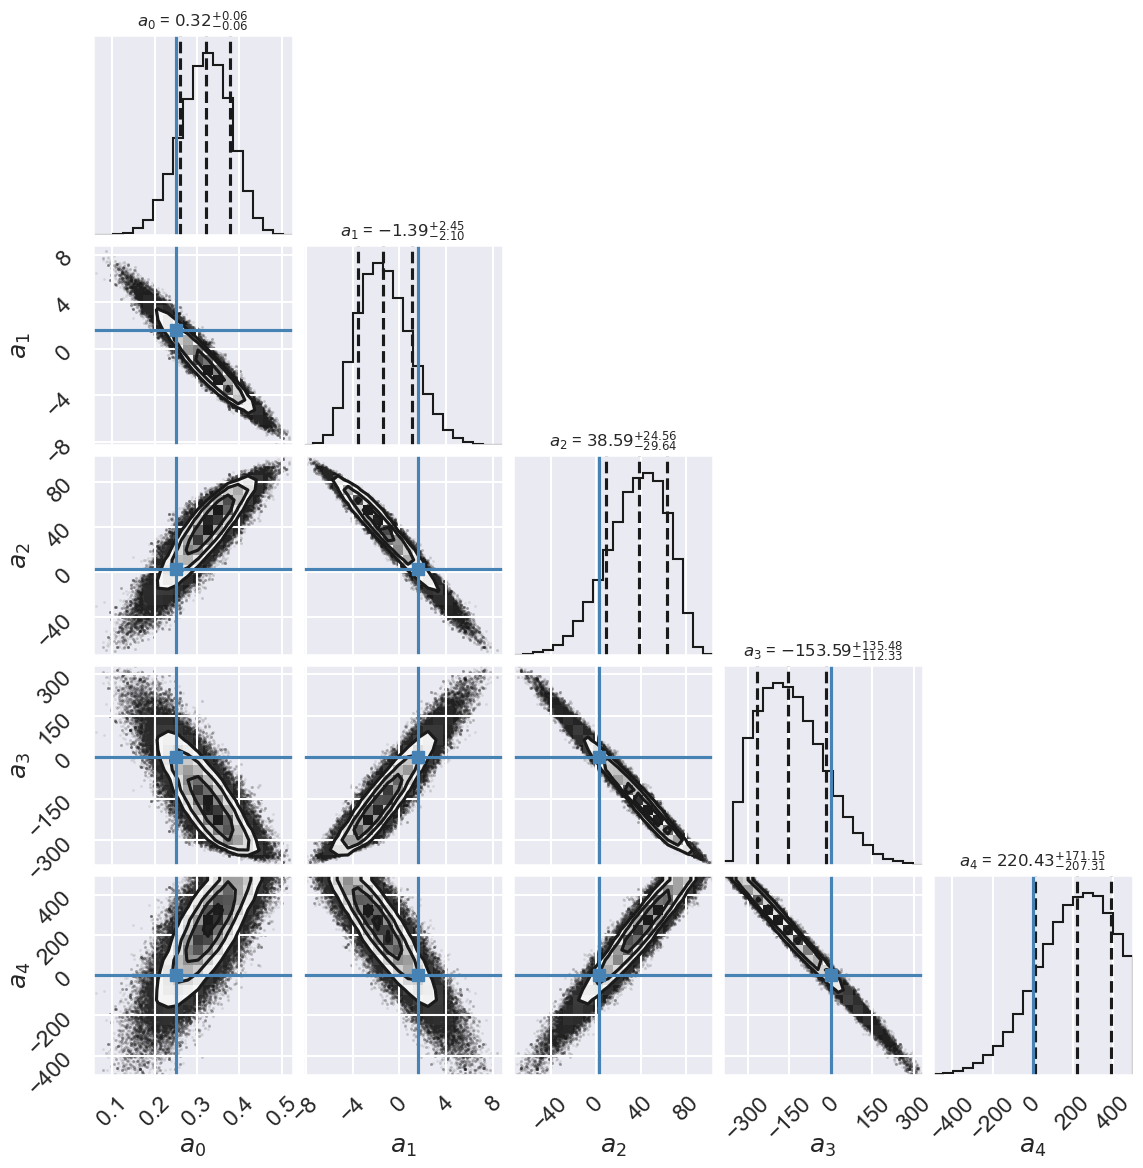

In [201]:
# Ndim = k_max+1, number of LEC we are keeping in taylor expansion. The coefficients are a_0,a_1,a_2,a_3, ......

Ndim=5     
A_true = [0.25, 1.5707963, 2.4674011, 1.2919282, 4.0587121,1.275082, 5.67486677]
extract_LEC(Ndim,A_true[:Ndim],"uniform","paper",C=0.05,Nd=10)

In [202]:
%%html

<style> 
 table { width:95% !important; }
 table td, table th, table tr {border: 2px solid black !important; 
                               text-align:center !important;
                               font-size: 12px;}
</style>

$\color{red}{\text{Solution}}$
$a_0$(true) = 0.25, $a_1$(true) = 1.57, $a_2$(true) = 2.47, $a_3$(true) = 1.29. Using data from arXiv:1511.03618


Using Nburn = 2000, NSteps = 5000, 50 walkers, 10 $x_j$ points, Uniform prior. Boundaries are chosen at $\pm 500$ along each $a_k$ direction. (Note that when the errors are not symmetric, values are represented as: estimated value,+right error,-left error) 

|$k$  |$k_{max}$| $a_0$ | $a_1$ | $a_2$ |
| :-: | :-: | :-----------: | :-----------: | :-------------: |
|  0  |  0  | $0.48 \pm 0.01$ |       |       |     
|  1  |  1  | $0.20 \pm 0.01$ | $2.56 \pm 0.11 $ |       |          
|  2  |  2  | $0.25 \pm 0.02$ | $1.58 \pm 0.40 $ | $3.31,+1.29,-1.30$ |          
|  2  |  3  | $0.27 \pm 0.04$ | $0.97,+1.08,-1.10$ | $8.05,+8.10,-7.95$ |  
|  2  |  4  | $0.32 \pm 0.06$ | $-1.37,+2.47,-2.09$ | $38.42,+24.61,-29.88$ | 
|  2  |  5  | $0.31 \pm 0.06$ | $-0.94,\pm 2.28$ | $32.67,+25.81,-27.24$ |




MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.551 (in total 250000 steps)


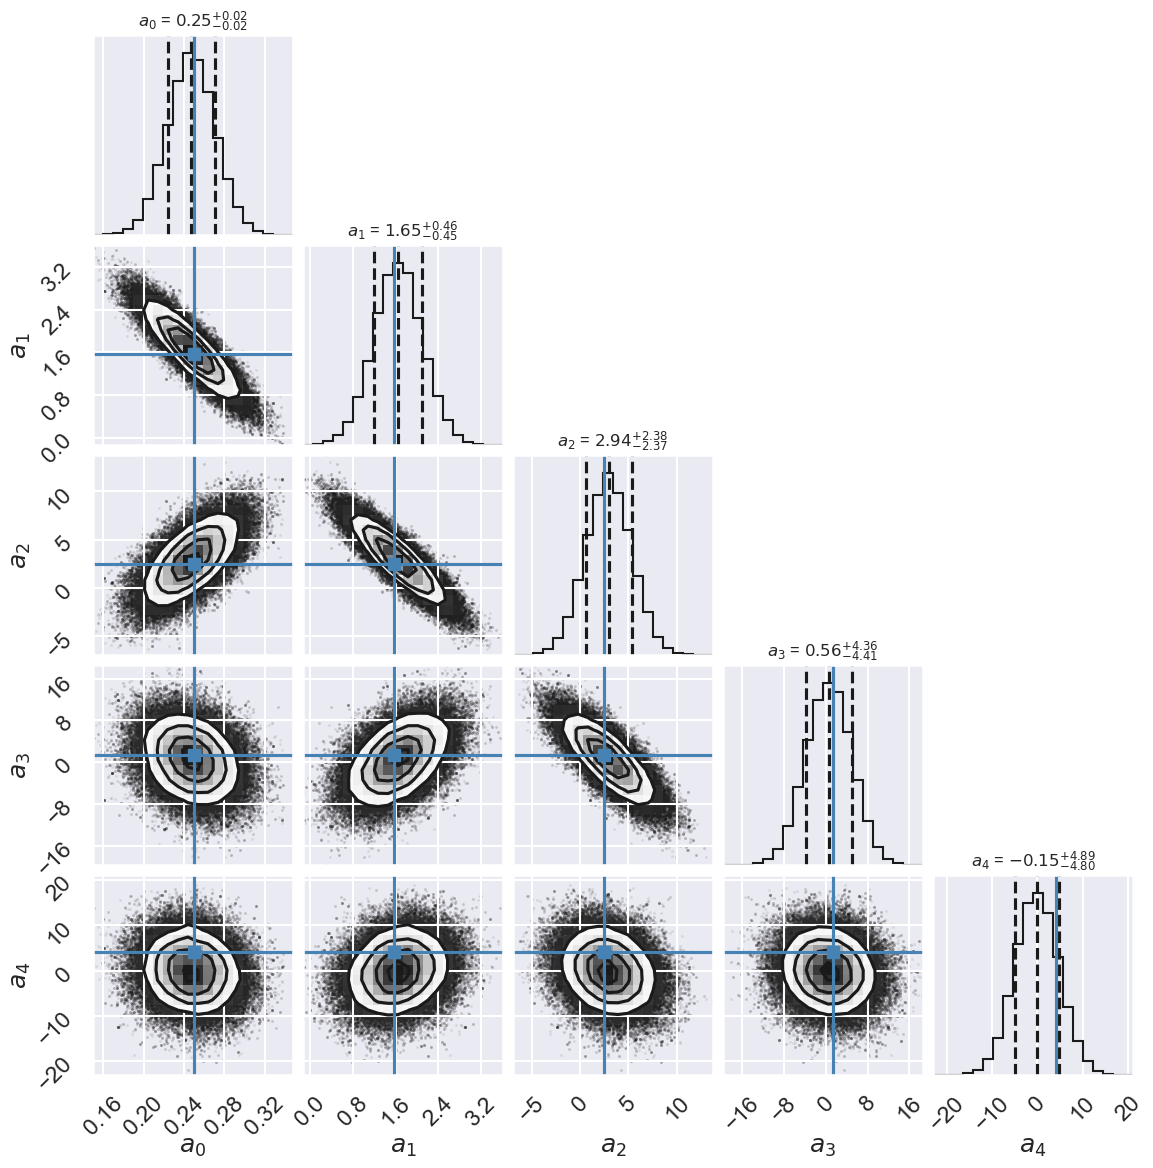

In [205]:
Ndim=5     
A_true = [0.25, 1.5707963, 2.4674011, 1.2919282, 4.0587121,1.275082, 5.67486677]
extract_LEC(Ndim,A_true[:Ndim],"gaussian","paper",C=0.05,Nd=10)

In [206]:
%%html

<style> 
 table { width:95% !important; }
 table td, table th, table tr {border: 2px solid black !important; 
                               text-align:center !important;
                               font-size: 12px;}
</style>

$\color{red}{\text{Solution}}$
$a_0$(true) = 0.25, $a_1$(true) = 1.57, $a_2$(true) = 2.47, $a_3$(true) = 1.29. Using data from arXiv:1511.03618


Using Nburn = 2000, NSteps = 5000, 50 walkers, 10 $x_j$ points, Gaussian prior, $\bar{a} = 5$. (Note that when the errors are not symmetric, values are represented as: estimated value,+right error,-left error) 

|$k$  |$k_{max}$| $a_0$ | $a_1$ | $a_2$ |
| :-: | :-: | :-----------: | :-----------: | :-------------: |
|  0  |  0  | $0.48 \pm 0.01$ |       |       |     
|  1  |  1  | $0.20 \pm 0.01$ | $2.55,\pm 0.11$ |       |          
|  2  |  2  | $0.25 \pm 0.02$ | $1.63,+0.38,-0.39$ | $3.12,+1.29,-1.25$ |          
|  2  |  3  | $0.25 \pm 0.02$ | $1.65,\pm 0.45$ | $2.94,+2.32,-2.29$ |  
|  2  |  4  | $0.25 \pm 0.02$ | $1.64,\pm 0.46$ | $2.99,+2.36,-2.38$ | 
|  2  |  5  | $0.25 \pm 0.02$ | $1.66,\pm 0.46$ | $2.88,+2.42,-2.37$ | 

### Comment about nature of priors

$\color{red}{(a)}$ Between the two priors, the gaussian one results in better optimization of the parameters, since it contrains the phase space the monte carlo walkers can move about, close to the true solution. Note that for truncating the series at order $k$, the estimates for the coefficients $a_k$ towards lower values of $k$ are more oscillatory for the uniform prior(since adding additional dimenision to a more "unconstrained" walker leads to more deviation from the actual solution) compared to a gaussian one. On that note, we see that using a least square estimate is equivalent to using a uniform prior. This is because, in a least square estimate, we seek $a_k$ that minimized $\chi^2$, without regard to which part of phase space do the solutions come from. 

$\color{red}{(b)}$ For the parameters $a_k$ themselves, we see that the ones accompanying a lower power of $x$ in the expansion $g_{th} = \sum_{k}a_kx^k$ are more "insensitive" to the prior. For the higher orders $k$, monte carlo returns posteriors that are very similar to the priors chosen (refer to the table for the gaussian prior case). This can be understood as follows:

For the expansion of the theory, we are working in a radius of convergence $|x|< 1$. This means that the terms in the expansion of $g_{th}(x) = \sum_{k}a_kx^k$ are increasingly smaller for larger k. If we look at the likelihood function,

$$ p(D|\{a_{k}\},I) = \prod_{j=1}^{N_d} \bigg (\frac{1}{\sqrt{2\pi}\sigma_j} \bigg )e^{-\frac{\chi^2}{2}}, ~~\chi^2 = \sum_{j=1}^{N_d} \bigg (\frac{d_j}{\sigma_j}-\sum_{k}\frac{a_{k}x^{k}}{\sigma_j} \bigg )^2$$

we see that for $\sigma_j$ that are reasonably of $O(1)$ (absolute scale), the larger k terms die out and don't contribute much to the likelihood function. Hence the posteriors for those $k$ values reflect the prior. In order for the posteriors to capture correlations from the data, we would want the terms $\frac{a_kx^k}{\sigma_j}$ to contribute more, hence $\sigma_j$ should be small.

$\color{red}{(c)}$ Correlations among coefficients:

The correlations are different for different choice of priors. Note that for the uniform prior, increasing the truncation order of the theory $k_{max}$ doesn't lead to a change in the magnitude of correlation among the $a_{k}$, which can be understood from the fact they all contribute simultaneously to the minimization of 

$$ \chi^2 = \sum_{j=1}^{N_d} \bigg (\frac{d_j}{\sigma_j}-\sum_{k}\frac{a_{k}x^{k}}{\sigma_j} \bigg )^2$$

Adding more k terms leads to a just constrained optimization in larger dimensional space. Since the different $k$ terms enter as a summand in the $\chi^2$ expression, all the coefficients corresponding to even powers are positively correlated amongst themselves, and all the odd powered ones are positively correlated amongst themselves. The correlations are negative only between even and odd $k$s.

For the gaussian prior, increasing the the number of $k$ terms in the expansion of the theory leads to an overall decrease in the degree of correlation with increasing $k_{max}$.


## Bonus solutions
### (a) Least Square Estimate

In [207]:
url = "https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat"
names = ['x_data', 'y_data', 'dy_data']

# Note that the data file uses one or more tabs as separators. So the regex '\t+' is needed
# and this calls for engine='python'
# Comment lines starting with '#' should be ignored
data = pandas.read_csv(url, names=names, sep='\t+', engine='python', comment='#')
#print(f'Read data from {url} into a pandas data frame with shape: {data.shape}')
#print('This data must be used to reproduce the results in Table III')
#display(data)

X = data['x_data'].to_numpy()
D = data['y_data'].to_numpy()
Sigma = data['dy_data'].to_numpy()

In [208]:
# Obtaining least square fit by minizming the log likelihood function. 
#Ndim = k_max+1
#A0 is the initial guess that the solver starts from

a_bar = 5
Ndim = 5
A0 = np.random.normal(loc=0.0, scale=a_bar, size=Ndim)

result = optimize.minimize(min_likelihood_optimize, A0, args=(X,D,Sigma))

In [209]:
x_pts = np.linspace(0.0,0.4,num=41)
True_func = (0.5+np.tan(0.5*np.pi*x_pts))**2

Least_square_estimate = np.zeros(len(True_func))

for k in range(Ndim):
    Least_square_estimate = Least_square_estimate+result.x[k]*np.power(x_pts,k)

Text(0, 0.5, 'g(x)')

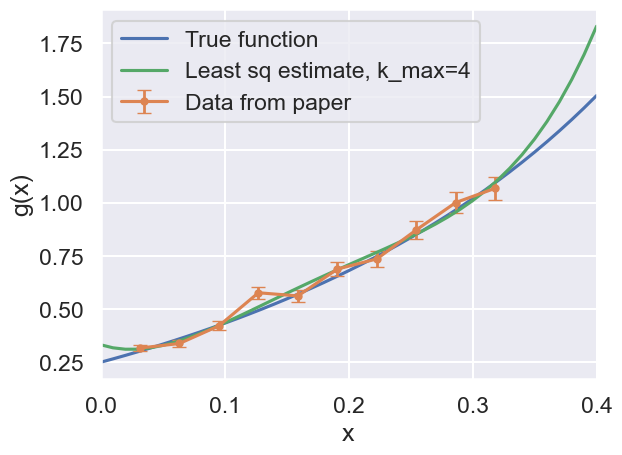

In [210]:
plt.figure()
plt.plot(x_pts,True_func, label = "True function")
plt.errorbar(X,D,yerr = Sigma, marker = "o",markersize = 5,elinewidth = 2,capsize =5, label = "Data from paper")
plt.plot(x_pts,Least_square_estimate,label = "Least sq estimate, k_max=4")
plt.legend(loc = 'best')
plt.xlim(0.0,0.4)
plt.xlabel("x")
plt.ylabel("g(x)")

### (b) Uniform_prior_estimate

(0.0, 0.4)

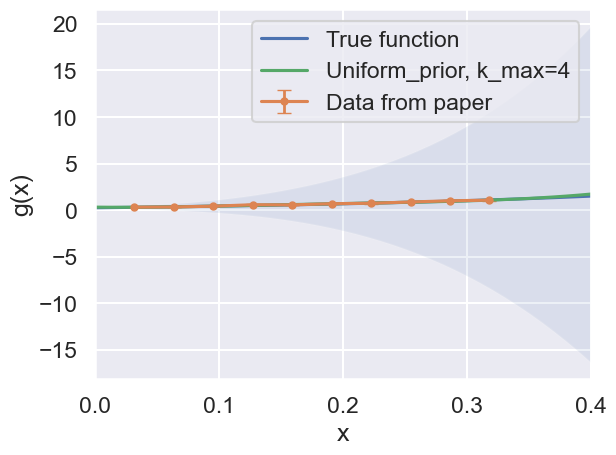

In [211]:
Ndim = 5
x_pts = np.linspace(0.0,0.4,num=41)
True_func = (0.5+np.tan(0.5*np.pi*x_pts))**2

Uniform_bayesian = np.zeros(len(True_func))

a_mean = np.array([0.32,-1.43,39.19,-157.67,226.31])
a_plus = np.array([0.06,2.48,24.27,136.81,169.14])
a_minus = np.array([0.06,2.06,29.90,110.44,208.07])

a_upper = np.add(a_mean,a_plus)
a_lower = np.subtract(a_mean,a_minus)

y = np.zeros(len(x_pts))
y_plus_error = np.zeros(len(x_pts))
y_minus_error = np.zeros(len(x_pts))

for k in range(Ndim):
    y_plus_error = y_plus_error+a_upper[k]*np.power(x_pts,k)
    y_minus_error = y_minus_error+a_lower[k]*np.power(x_pts,k)
    y = y+a_mean[k]*np.power(x_pts,k)

plt.figure()
plt.plot(x_pts,True_func, label = "True function")
plt.errorbar(X,D,yerr = Sigma, marker = "o",markersize = 5,elinewidth = 2,capsize =5, label = "Data from paper")
plt.plot(x_pts,y,label = "Uniform_prior, k_max=4")
plt.fill_between(x_pts,y_minus_error,y_plus_error,alpha=0.1)
plt.xlabel("x")
plt.ylabel("g(x)")
plt.legend(loc = 'best')
plt.xlim(0.0,0.4)

### (c) Gaussian prior estimate

(0.0, 0.4)

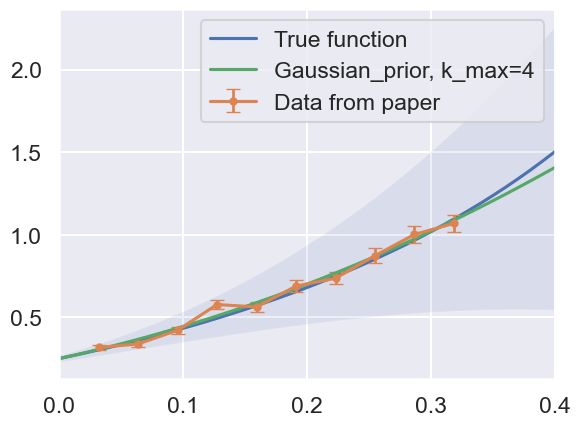

In [212]:
Ndim=4

a_mean = np.array([0.25,1.64,3.01,0.32,0.01])
a_plus = np.array([0.02,0.46,2.35,4.32,4.87])
a_minus = np.array([0.02,0.46,2.36,4.40,4.98])


a_upper = np.add(a_mean,a_plus)
a_lower = np.subtract(a_mean,a_minus)

y = np.zeros(len(x_pts))
y_plus_error = np.zeros(len(x_pts))
y_minus_error = np.zeros(len(x_pts))

for k in range(Ndim):
    y_plus_error = y_plus_error+a_upper[k]*np.power(x_pts,k)
    y_minus_error = y_minus_error+a_lower[k]*np.power(x_pts,k)
    y = y+a_mean[k]*np.power(x_pts,k)

plt.figure()
plt.plot(x_pts,True_func, label = "True function")
plt.errorbar(X,D,yerr = Sigma, marker = "o",markersize = 5,elinewidth = 2,capsize =5, label = "Data from paper")
plt.plot(x_pts,y,label = "Gaussian_prior, k_max=4")
plt.fill_between(x_pts,y_minus_error,y_plus_error,alpha=0.1)
plt.legend(loc = 'best')
plt.xlim(0.0,0.4)

## Analysis with reduced error (c) and increased number of data points (Gaussian prior)

### Using c = 0.01, $n_{d}$ = 10

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.551 (in total 250000 steps)


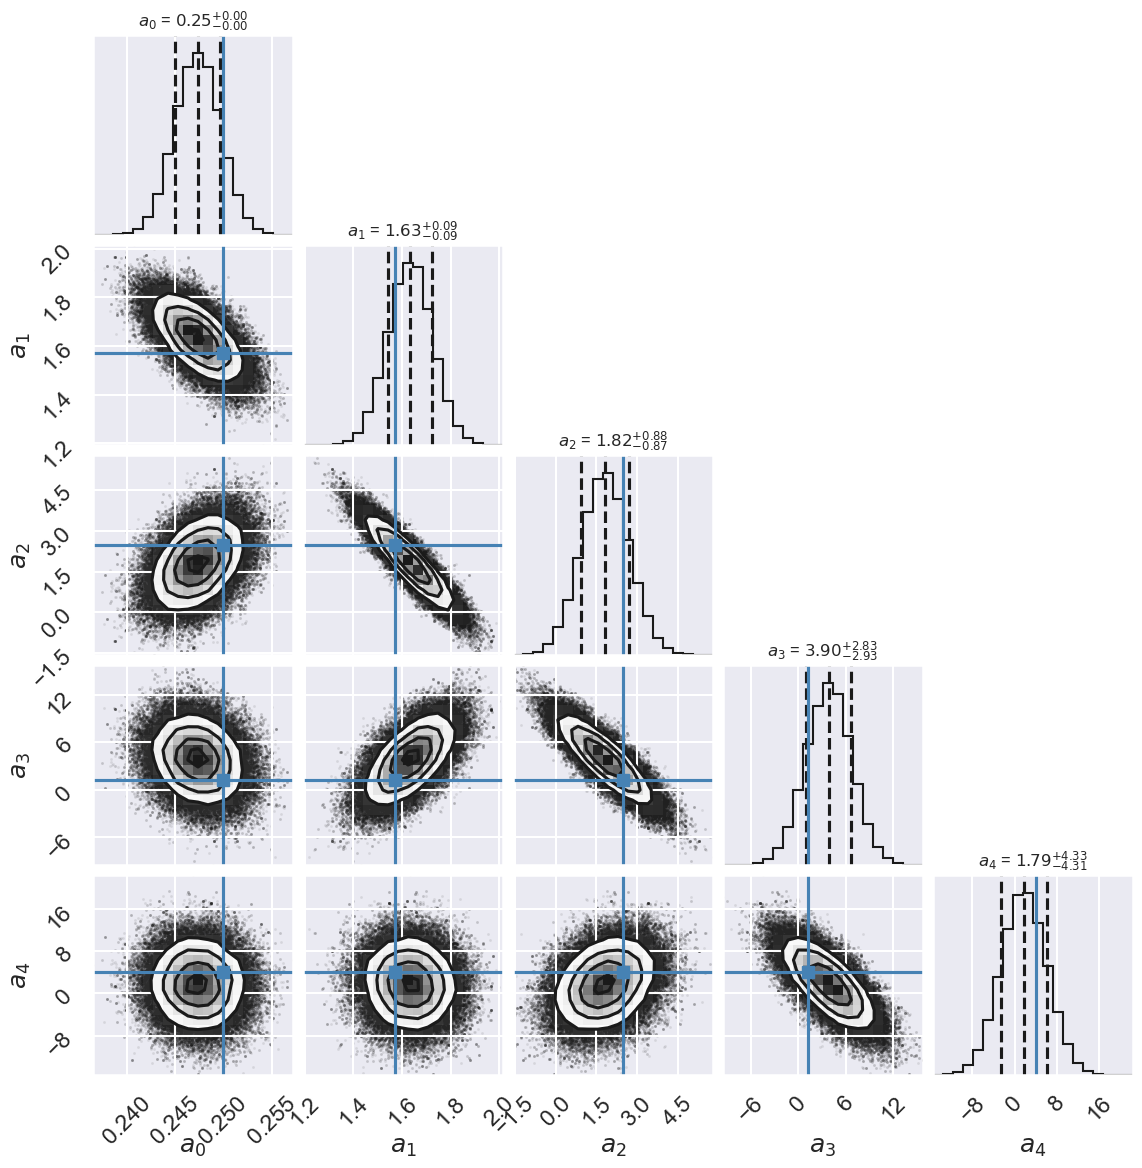

In [219]:
Ndim=5     
A_true = [0.25, 1.5707963, 2.4674011, 1.2919282, 4.0587121,1.275082, 5.67486677]
extract_LEC(Ndim,A_true[:Ndim],"gaussian","self",c=0.01,Nd=10)

Correlation amongst coefficients - Note that in this case, the higher k values don't have their marginalized posterior same as that of prior ($a_4$ peaks at 1.79, compared to 0.15 for 5% error rate). Also, decreasing c results in increasing correlation between higher $a_k$, for example $a_3$ and $a_4$ (compare to c = 0.05 case) 

### Using c = 0.05, $n_{d}$ = 100

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.551 (in total 250000 steps)


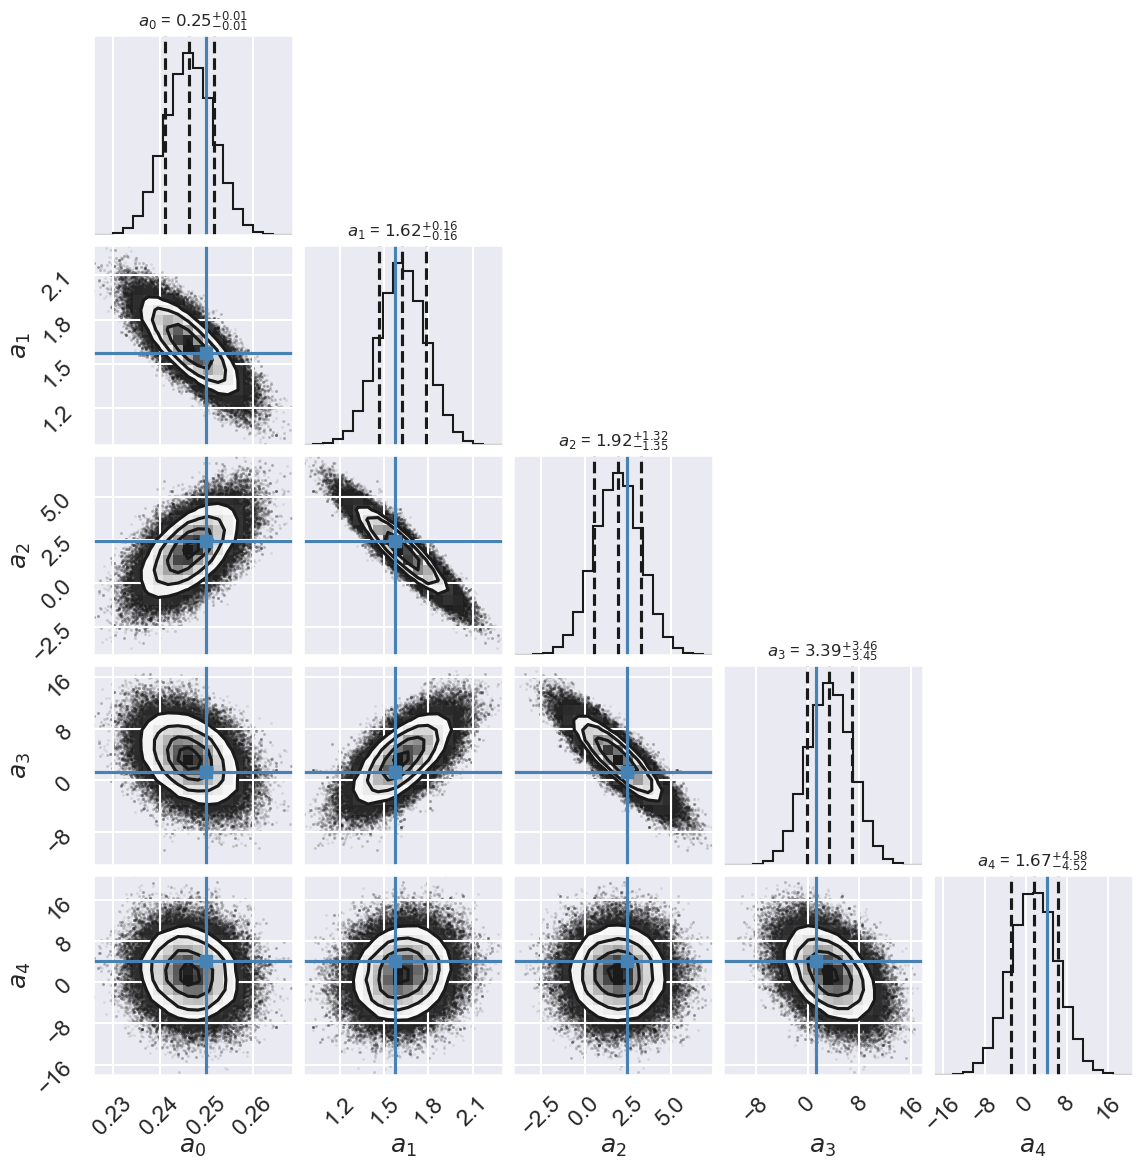

In [220]:
Ndim=5     
A_true = [0.25, 1.5707963, 2.4674011, 1.2919282, 4.0587121,1.275082, 5.67486677]
extract_LEC(Ndim,A_true[:Ndim],"gaussian","self",c=0.05,Nd=100)

Increasing the number of data points has the same effect on the posteriors of $a_k$ for large k, similar to decreasing the $\sigma_j$. This is because, more terms contribute to the $\chi^2$ in the likelihood function, resulting in $O(n_d)$ increase of $a_kx^k$ terms (where $n_d$ is the number of data points). This increases the weight of $\frac{(O_{n_d})a_kx^k}{\sigma_j}$ terms in the sum, even if $\sigma_j$ are themselves larger